<h1> <b>Simple Ideas for Crypting Image</b> </h1>

In [1]:
import numpy as np
import cv2
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
os.chdir('/Users/massimomontanaro/Desktop/album')

<h2> 1. Playing with indices </h2>
<p> We create a new image where in each row we put a random row of the original one. Then the same is done randomizing the columns of the new one. We need to know the seed to reverse the process and retrieve the original image from the corrupted one<p> 

In [3]:
def _convert2array(img):
    img_array = np.asanyarray(img)/255
    return img_array

In [4]:
def _random_array(size, channels, seed):
    
    '''
        Return a size*2*channels array where: 
        - column[0] is an arange from 0 to size 
        - column[1] is a random sequence of the same numbers of column[0] generated from seed
    '''
    
    np.random.seed(seed)
    array = np.empty(shape=(size,2,channels),dtype=int)
    
    for i in range(array.shape[2]):
        array[:,0,i] = np.arange(0,array.shape[0],1)
        array[:,1,i] = np.random.choice(range(array.shape[0]), size=array.shape[0], replace=False)
        
    return array

In [5]:
def _transform(img_array, ind, ax, reverse=False):
    '''
        Create a corrupted version of the imag_array in input 
        switching row (or columns -ax=0 row, ax=1 col-) 
        for each channels of the image. 
        If reverse is set to True, then the original image is reconstructed from the corrupted one
    '''
    array = np.empty(img_array.shape)
    if ax == 0:
        for i in range(img_array.shape[2]):
            array[ind[:,0 if reverse is False else 1,i],:,i] = img_array[ind[:,1 if reverse is False else 0,i],:,i]
    elif ax == 1:
        for i in range(img_array.shape[2]):
            array[:,ind[:,0 if reverse is False else 1,i],i] = img_array[:,ind[:,1 if reverse is False else 0,i],i]
    return array

In [6]:
def _hide_msg(img_array, text, font_size=2, coor=None, color=(0,0,0), thick=2):
    
    copy = img_array.copy()
    copy = cv2.putText(copy, 
                       text=text, 
                       org=(int(img_array.shape[1]/2), int(img_array.shape[0]/2)) if coor is None else coor, 
                       fontFace=cv2.FONT_HERSHEY_COMPLEX, 
                       fontScale=font_size, 
                       color=color, 
                       thickness=thick, 
                       lineType=cv2.LINE_AA)
    #copy = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)
    return copy

In [7]:
def fast_encrypt(image_path_or_array, seed):
    
    if type(image_path_or_array) is str:
        image = Image.open(image_path_or_array)
        img_array = _convert2array(image)
    elif type(image_path_or_array) is np.ndarray:
        img_array = image_path_or_array
    
    shape = img_array.shape    
    
    rows = _random_array(size=shape[0],  channels=shape[2], seed=seed)
    cols = _random_array(size=shape[1],  channels=shape[2], seed=seed)
    
    row_corr = _transform(img_array, rows, ax=0)
    corrupted = _transform(row_corr, cols, ax=1)
    
    return corrupted

In [8]:
def fast_decrypt(image_path_or_array, seed):
    
    if type(image_path_or_array) is str:
        image = Image.open(image_path_or_array)
        img_array = _convert2array(image)
    elif type(image_path_or_array) is np.ndarray:
        img_array = image_path_or_array
    
    shape = img_array.shape    
    
    rows = _random_array(size=shape[0],  channels=shape[2], seed=seed)
    cols = _random_array(size=shape[1],  channels=shape[2], seed=seed)
    
    col_rec = _transform(img_array, cols, ax=1, reverse=True)
    recovered = _transform(col_rec, rows, ax=0, reverse=True)
    
    return recovered

<h4> Encryption Routine </h4>

In [9]:
img = _convert2array(Image.open('animals.jpeg'))
seed = 17
shape = img.shape
rows = _random_array(shape[0], channels=shape[2], seed=seed)
cols = _random_array(shape[1], channels=shape[2], seed=seed)
# We can do other more complex stuff here, but the same must be reversed in decryption routine
corr_row = _transform(img, rows, ax=0)
corrupted = _transform(corr_row, cols, ax=1)

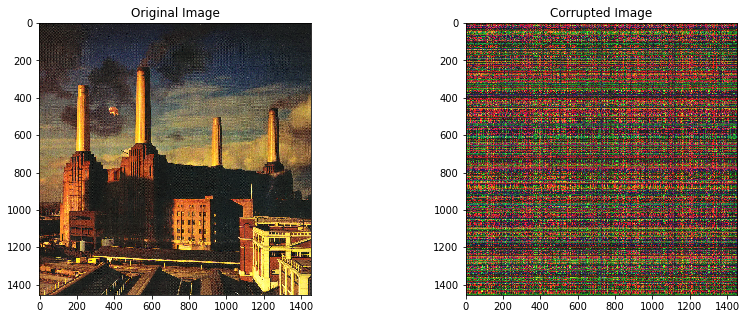

In [10]:
plt.figure(figsize=(14,5))
plt.subplot(121, title='Original Image')
plt.imshow(img)
plt.subplot(122, title='Corrupted Image')
plt.imshow(corrupted)
plt.show()

<h4> Decryption Routine </h4>
<p> We may need to open the image first and then convert it to array ( <i>image = _convert2array(Image.open(path))</i> ), but in this case we already have the array. </p>

In [11]:
shape = corrupted.shape
seed = 17
rows = _random_array(shape[0], channels=shape[2], seed=seed)
cols = _random_array(shape[1], channels=shape[2], seed=seed)
# remember to reverse all the operations of encryption routine
rec_col = _transform(corrupted, cols, ax=1, reverse=True)
recovered = _transform(rec_col, rows, ax=0, reverse=True)

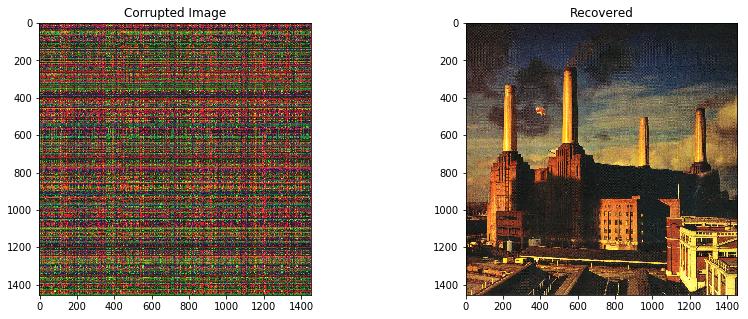

In [12]:
plt.figure(figsize=(14,5))
plt.subplot(121, title='Corrupted Image')
plt.imshow(corrupted)
plt.subplot(122, title='Recovered')
plt.imshow(recovered)
plt.show()

<h4> Automating the process </h4>

In [13]:
# encryption
corrupted = fast_encrypt('electric_cafe.jpeg', seed=17)
# decryption
recovered = fast_decrypt(corrupted, seed=17)

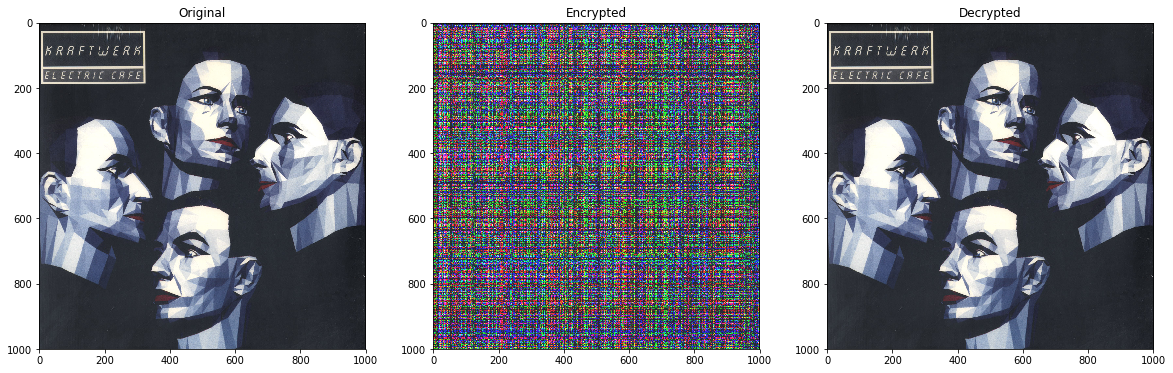

In [14]:
plt.figure(figsize=(20, 6))
plt.subplot(131, title='Original')
plt.imshow(_convert2array(Image.open('/Users/massimomontanaro/Desktop/album/electric_cafe.jpeg')))
plt.subplot(132, title='Encrypted')
plt.imshow(corrupted)
plt.subplot(133, title='Decrypted')
plt.imshow(recovered)
plt.show()

<h4> Hiding text in images </h4>

In [15]:
img = _convert2array(Image.open('physical_graffiti.jpeg'))
corrupted = fast_encrypt(img, 17)
mex = _hide_msg(corrupted, 'LED ZEPPELIN', font_size=3, coor=(80,400), thick=5, color=(0,0,0))
recovered = fast_decrypt(mex, 17)

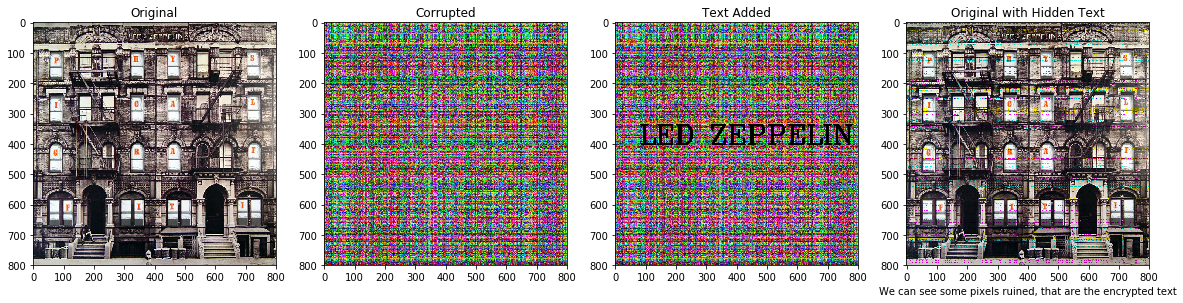

In [16]:
plt.figure(figsize=(20, 6))
plt.subplot(141, title='Original')
plt.imshow(img)
plt.subplot(142, title='Corrupted')
plt.imshow(corrupted)
plt.subplot(143, title='Text Added')
plt.imshow(mex)
plt.subplot(144, title='Original with Hidden Text', xlabel='We can see some pixels ruined, that are the encrypted text')
plt.imshow(recovered)
plt.show()

<p> If we want to access to the hidden text we need to re-encrypt the image with the same seed </p>

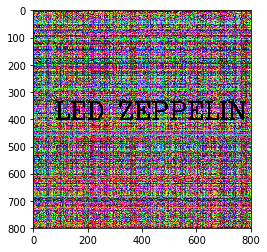

In [17]:
visible_text = fast_encrypt(recovered, 17)
plt.imshow(visible_text)
plt.show()

<h2> 2. Linear Algebra </h2>
<p> We can consider our image as a set of vectors in some vector space. If we have two vector spaces and if we know what is the relation between them, we can describe our set of vectors in terms of the second vectrs space with a transformation matrix. If we want to retrieve our original vectors in the first vector space, we simply need to calculate the inverse of that transformation matrix. That's all, we can encrypt with the dot product between a transformation matrix (here called <i>mask</i>) and our image, and then recover the original image with the dot product between the inverse of the transformation matrix and the encrypted image.</p>

In [18]:
def _random_mask(img_array, seed, ax=0):
    '''
        Returns an array with same dimensions of the array in input with random values between 0 and 1
    '''
    np.random.seed(seed)
    array = np.random.uniform(size=(img_array.shape[0 if ax==0 else 1],img_array.shape[0 if ax==0 else 1], img_array.shape[2]))
    return array

In [19]:
def _inverse_mask(array):
    '''
        Finds the inverse matrix for each channel of the array in input
    '''
    inverse_array = np.empty(array.shape)
    for i in range(array.shape[2]):
        inverse_array[:,:,i] = np.linalg.inv(array[:,:,i])
    
    return inverse_array

In [20]:
def _dot_array(array_1, array_2):
    '''
        Performs the dot array for each channel of the arrays in input, which must have the same number of channels
    '''
    array = np.empty(shape=(array_1.shape[0], array_2.shape[1], array_2.shape[2]))
    for i in range(array_2.shape[2]):
        array[:,:,i] = np.dot(array_1[:,:,i], array_2[:,:,i])
    
    return array

In [21]:
def _rescale(array, min_max=None):
    
    '''
        If min_max is set to None, it returns the input array scaled between 0 and 1 
        and a list of tuples with the original min and max value,
        i.e. [(min, max), (min, max)] (the length of the list will be equal to array.shape[2]).
        If you pass a list of tuples then arra[:,:,i] will be scaled between [min_max][i][0], [min_max][i][1].
    '''
    
    shape = array.shape
    if len(shape) == 3:
        channels = shape[2]
    else:
        channels = 1
        array = array.reshape(shape[0], shape[1], channels)
    
    scaled_array = np.empty(shape=(shape[0], shape[1], channels))
    
    if min_max is not None:
        
        for i in range(channels):
            min_, max_ = (np.min(array[:,:,i]), np.max(array[:,:,i]))
            scaled_array[:,:,i] = np.interp(array[:,:,i], (min_, max_), min_max[i])
        if channels == 1:
            return scaled_array[:,:,0]
        else:
            return scaled_array
    
    else:
        min_max = []
        for i in range(channels):
            min_, max_ = (np.min(array[:,:,i]), np.max(array[:,:,i]))
            scaled_array[:,:,i] = np.interp(array[:,:,i], (min_, max_), (0,1))
            min_max.append((min_, max_))
        if channels == 1:
            return min_max, scaled_array[:,:,0]
        else:
            return min_max, scaled_array

<h4> Encryption Routine </h4>

In [22]:
image = Image.open('abbey_road.jpeg')
img = _convert2array(image)
seed = 17
mask = _random_mask(img, seed)
min_max_corr, scaled_corrupted = _rescale(_dot_array(mask, img))

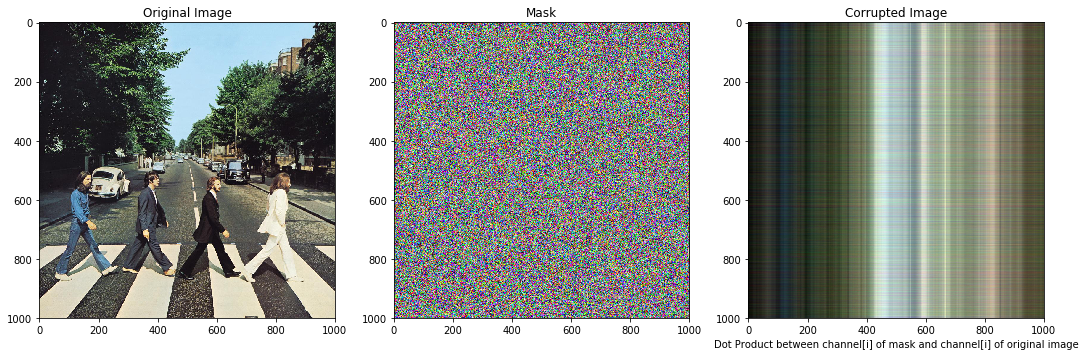

In [23]:
plt.figure(figsize=(18,8))
plt.subplot(131, title='Original Image')
plt.imshow(img)
plt.subplot(132, title='Mask')
plt.imshow(mask)
plt.subplot(133, title='Corrupted Image', xlabel='Dot Product between channel[i] of mask and channel[i] of original image')
plt.imshow(scaled_corrupted)
plt.show()

<h4> Decryption Routine </h4>
<p> If we have the seed we can regenerate the mask to calculate its inverse.</p>

In [24]:
mask = _random_mask(scaled_corrupted, 17)
inv_mask = _inverse_mask(mask)
min_max_inv, scaled_inv = _rescale(inv_mask)

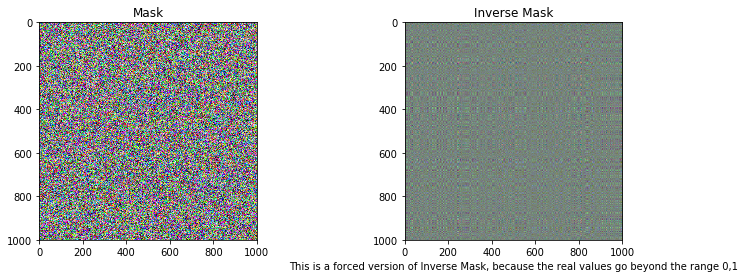

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(121, title='Mask')
plt.imshow(mask)
plt.subplot(122, title='Inverse Mask', xlabel='This is a forced version of Inverse Mask, because the real values go beyond the range 0,1')
plt.imshow(scaled_inv)
plt.show()

<p>We need the corrupted image and its real (min, max) values<p>

In [26]:
real_corr = _rescale(scaled_corrupted, min_max_corr)
real_inv = _rescale(scaled_inv, min_max_inv)
recovered = _dot_array(real_inv, real_corr)
min_max_rec, scaled_rec = _rescale(recovered)

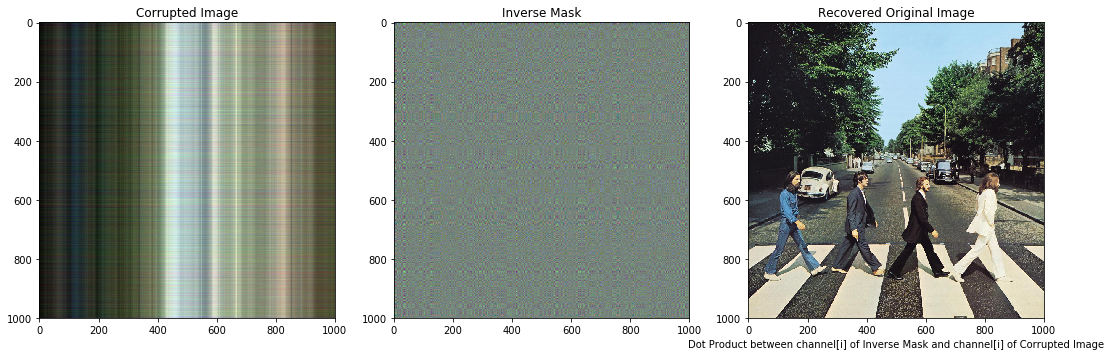

In [27]:
plt.figure(figsize=(18,10))
plt.subplot(131, title='Corrupted Image')
plt.imshow(scaled_corrupted)
plt.subplot(132, title='Inverse Mask')
plt.imshow(scaled_inv)
plt.subplot(133, title='Recovered Original Image', xlabel='Dot Product between channel[i] of Inverse Mask and channel[i] of Corrupted Image')
plt.imshow(scaled_rec)
plt.show()

<h2> 3. Dimensionality Reduction </h2>
<p> This is the most interesting and it uses the Principal Component Analysis, an unsupervised learning algorithm, to compress the information contained in the image. Let's look how it works only on one channel. </p>

In [28]:
def _col_mean(img_array):
    array = np.empty(shape=img_array.shape)
    
    for i in range(img_array.shape[1]):
        array[:,i] = np.mean(img_array[:,i])
        
    return array

<h4> Ecnryption Routine

In [29]:
image = Image.open('london_calling.jpeg')
img = _convert2array(image)
shape = img.shape

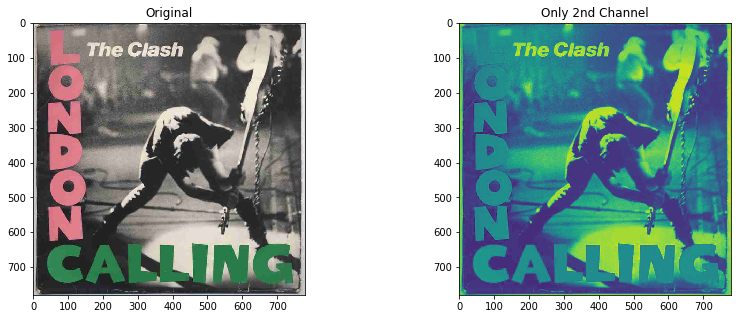

In [30]:
plt.figure(figsize=(14,5))
plt.subplot(121, title='Original')
plt.imshow(img)
plt.subplot(122, title='Only 2nd Channel')
plt.imshow(img[:,:,1])
plt.show()

In [31]:
img = img[:,:,1]

In [32]:
mean_mat = _col_mean(img)
pca = PCA(0.99) # here we are saying that we choose n components such that these are able to preserve the 0.99 of variance/information in the image
pca.fit(img)
transf_img = pca.transform(img)
comps = pca.components_
min_max_transf, scaled_transf = _rescale(transf_img)
min_max_comps, scaled_comps = _rescale(comps)

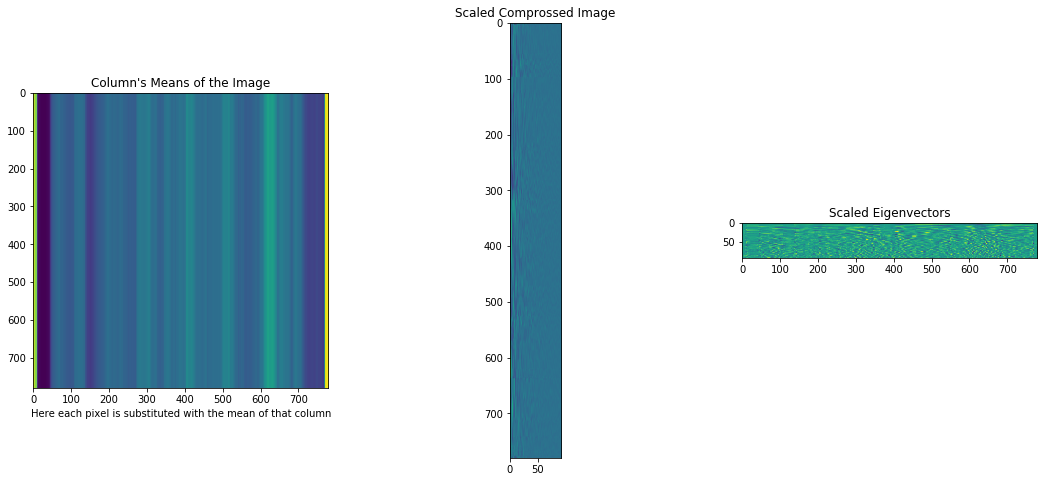

In [33]:
plt.figure(figsize=(18,8))
plt.subplot(131, title='Column\'s Means of the Image', xlabel='Here each pixel is substituted with the mean of that column')
plt.imshow(mean_mat)
plt.subplot(132, title='Scaled Comprossed Image')
plt.imshow(scaled_transf)
plt.subplot(133, title='Scaled Eigenvectors')
plt.imshow(scaled_comps)
plt.show()

<h4> Decryption Routine </h4>

In [34]:
rec_transf_img = _rescale(scaled_transf, min_max_transf)
rec_comps = _rescale(scaled_comps, min_max_comps)
rec = np.dot(rec_transf_img, rec_comps)
recovered = rec + mean_mat

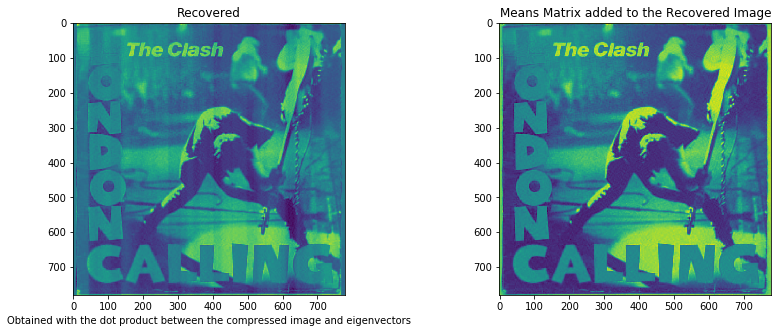

In [35]:
plt.figure(figsize=(14,5))
plt.subplot(121, title='Recovered', xlabel='Obtained with the dot product between the compressed image and eigenvectors')
plt.imshow(rec)
plt.subplot(122, title='Means Matrix added to the Recovered Image')
plt.imshow(recovered)
plt.show()